# **Proyecto de Minería de Datos: Clasificación de Clientes en Telecomunicaciones**

### **Autor:**  
**Deyvis Quispe Mamani**

### **Curso:**  
**Minería de Datos**

### **Docente:**  
**Abel Ángel Sullón Macalupu**

---

### **Descripción del Proyecto**

El presente trabajo aplica técnicas de **minería de datos y aprendizaje automático** para abordar un problema de **clasificación** en el contexto de una empresa de telecomunicaciones.  
El objetivo principal es **predecir si un cliente abandonará el servicio (Churn)** en función de características relacionadas con su tipo de contrato, tiempo de permanencia y segmento de cliente.

Se construye un flujo de trabajo completo que incluye:

1. **Carga y exploración de datos.**  
2. **División en conjuntos de entrenamiento y prueba.**  
3. **Preprocesamiento** de variables numéricas y categóricas mediante *pipelines*.  
4. **Entrenamiento de modelos de clasificación** (Regresión Logística, Bosques Aleatorios, SVM, KNN).  
5. **Evaluación de desempeño** utilizando métricas como *accuracy* y *ROC-AUC*.  
6. **Visualización de resultados** con matriz de confusión y curva ROC.  
7. **Guardado del modelo entrenado** con `joblib` y creación de funciones de predicción para uso posterior.

---

### **Estructura del Archivo**

El notebook sigue una estructura modular inspirada en la guía base utilizada en clase, organizada en secciones numeradas que facilitan la lectura y la ejecución secuencial del flujo de trabajo de minería de datos.

---

### **Palabras clave**
`Minería de Datos`, `Clasificación`, `Aprendizaje Automático`, `Churn Prediction`, `Python`, `Scikit-learn`

---



In [1]:
# =========================================
# 1) Cargar datos y objetivo
# =========================================
import os, json, warnings, platform, datetime
import numpy as np
import pandas as pd
import joblib
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_FILE = "/content/telecom_churn_data.csv"     # <-- data
TARGET    = "Churn"                       # 'Yes' / 'No'
assert os.path.exists(DATA_FILE), f"No se encuentra {DATA_FILE}"

df = pd.read_csv(DATA_FILE)
print("Dimensiones:", df.shape)
print("Columnas:", list(df.columns))
print("Previsualización:")
display(df.head())

print("Distribución de objetivo:")
print(df[TARGET].value_counts(normalize=True).round(3))

# Separación X / y
X = df.drop(columns=[TARGET])
y = df[TARGET]


Dimensiones: (1800, 4)
Columnas: ['Customer segment', 'Contract type', 'Tenure months', 'Churn']
Previsualización:


,Customer segment,Contract type,Tenure months,Churn
0,Small Business,One Year,49,Yes
1,Consumer,One Year,20,No
2,Enterprise,Month-to-Month,19,No
3,Small Business,One Year,9,No
4,Consumer,One Year,0,Yes


Distribución de objetivo:
Churn
No     0.781
Yes    0.219
Name: proportion, dtype: float64


In [3]:
# =========================================
# 2) Dividir en train / test
# =========================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
X_train.shape, X_test.shape


((1350, 3), (450, 3))

In [4]:
# =========================================
# 3) Preprocesamiento (numérico + categórico)
# =========================================
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_features = X.select_dtypes(include=["int64","float64","int32","float32"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_pipe = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_features),
        ("cat", categorical_pipe, cat_features),
    ]
)
num_features, cat_features


(['Tenure months'], ['Customer segment', 'Contract type'])

In [5]:
# =========================================
# 4) Modelos a comparar
# =========================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models = {
    "logreg": LogisticRegression(max_iter=500, random_state=RANDOM_STATE),
    "rf": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE),
    "svm": SVC(probability=True, random_state=RANDOM_STATE),
    "knn": KNeighborsClassifier(n_neighbors=15)
}
list(models.keys())


['logreg', 'rf', 'svm', 'knn']

In [6]:
# =========================================
# 5) Entrenamiento y evaluación
# =========================================
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

results = []
fitted = {}

for name, clf in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    fitted[name] = pipe

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    try:
        auc = roc_auc_score((y_test=="Yes").astype(int), y_proba) if y_proba is not None else np.nan
    except Exception:
        auc = np.nan

    results.append({"model": name, "accuracy": acc, "roc_auc": auc})

res_df = pd.DataFrame(results).sort_values(by=["roc_auc","accuracy"], ascending=False)
display(res_df)

best_name = res_df.iloc[0]["model"]
best_model = fitted[best_name]
print("Mejor modelo:", best_name)


,model,accuracy,roc_auc
0,logreg,0.784444,0.743391
3,knn,0.766667,0.701487
1,rf,0.722222,0.644669
2,svm,0.782222,0.628363


Mejor modelo: logreg


              precision    recall  f1-score   support

          No       0.79      0.99      0.88       352
         Yes       0.57      0.04      0.08        98

    accuracy                           0.78       450
   macro avg       0.68      0.52      0.48       450
weighted avg       0.74      0.78      0.70       450



<Figure size 640x480 with 0 Axes>

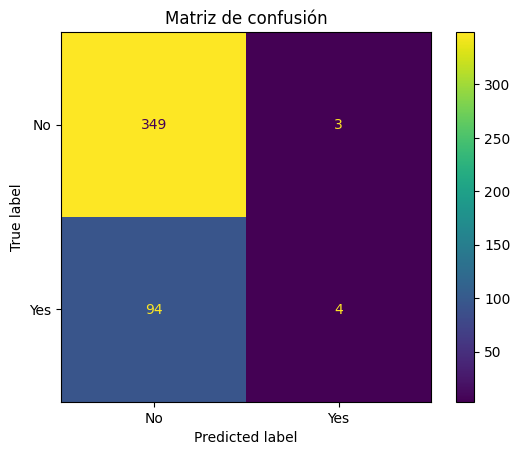

In [7]:
# =========================================
# 6) Matriz de confusión y reporte
# (Gráficos con matplotlib; una figura por gráfico)
# =========================================
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best, labels=["No","Yes"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No","Yes"])

plt.figure()
disp.plot(values_format="d")
plt.title("Matriz de confusión")
plt.show()


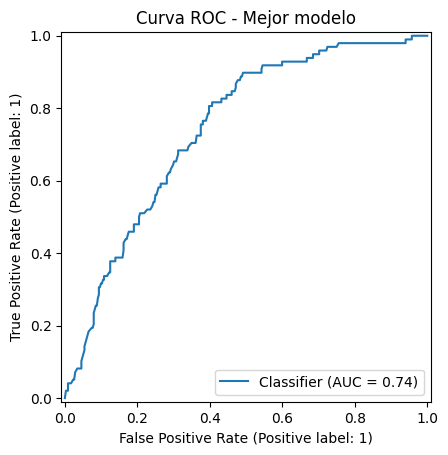

In [8]:
# =========================================
# 7) Curva ROC
# =========================================
from sklearn.metrics import RocCurveDisplay

if hasattr(best_model, "predict_proba"):
    y_proba_best = best_model.predict_proba(X_test)[:,1]
    RocCurveDisplay.from_predictions((y_test=="Yes").astype(int), y_proba_best)
    import matplotlib.pyplot as plt
    plt.title("Curva ROC - Mejor modelo")
    plt.show()
else:
    print("El modelo no soporta predict_proba; se omite ROC.")


In [9]:
# =========================================
# 8) Persistencia
# =========================================
ARTIFACT_BEST = "model_best.joblib"
ARTIFACT_PREP = "preprocess.joblib"

joblib.dump(best_model, ARTIFACT_BEST)
# preprocesador por separado:
joblib.dump(preprocess, ARTIFACT_PREP)

os.path.exists(ARTIFACT_BEST), os.path.exists(ARTIFACT_PREP)


(True, True)

In [10]:
# =========================================
# 9) Esquema de entrada y funciones predict_* para servir
# =========================================
INPUT_SCHEMA = {
    "Customer segment": "string",
    "Contract type": "string",
    "Tenure months": "number"
}

def _make_df_from_payload(d):
    return pd.DataFrame([d])[list(INPUT_SCHEMA.keys())]

def predict_one(payload: dict):
    mdl = joblib.load("model_best.joblib")
    X_one = _make_df_from_payload(payload)
    proba = mdl.predict_proba(X_one)[0,1] if hasattr(mdl, "predict_proba") else None
    pred  = mdl.predict(X_one)[0]
    return {"prediction": str(pred), "proba_yes": float(proba) if proba is not None else None}

def predict_batch(payload_list):
    mdl = joblib.load("model_best.joblib")
    Xb = pd.DataFrame(payload_list)[list(INPUT_SCHEMA.keys())]
    out_pred = mdl.predict(Xb)
    proba = mdl.predict_proba(Xb)[:,1] if hasattr(mdl, "predict_proba") else None
    return pd.DataFrame({
        **{k: Xb[k] for k in Xb.columns},
        "pred": out_pred,
        "proba_yes": proba if proba is not None else np.nan
    })

payload_one = { k: (0 if str(t).startswith(("int","float")) else ("",)[0]) for k,t in INPUT_SCHEMA.items() }
payload_one


{'Customer segment': '', 'Contract type': '', 'Tenure months': ''}

In [11]:
# =========================================
# 10) Ejemplos de uso de inferencia
# =========================================
samples_json = """
[
  {"Customer segment": "Consumer",      "Contract type": "Month-to-Month", "Tenure months": 2},
  {"Customer segment": "Small Business","Contract type": "One Year",       "Tenure months": 15},
  {"Customer segment": "Enterprise",    "Contract type": "Two Year",       "Tenure months": 25},
  {"Customer segment": "Enterprise",    "Contract type": "Month-to-Month", "Tenure months": 1},
  {"Customer segment": "Consumer",      "Contract type": "One Year",       "Tenure months": 3}
]
""".strip()

import json
samples_from_json = json.loads(samples_json)
res = predict_batch(samples_from_json)
res.head()


,Customer segment,Contract type,Tenure months,pred,proba_yes
0,Consumer,Month-to-Month,2,Yes,0.502673
1,Small Business,One Year,15,No,0.095863
2,Enterprise,Two Year,25,No,0.030361
3,Enterprise,Month-to-Month,1,No,0.394118
4,Consumer,One Year,3,No,0.129063
